In [5]:
from __future__ import print_function, division, absolute_import
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.colors as colors

In [6]:
from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O, abel_inversion, CalcInvPerfO
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
#from SimulateGroupDelayDispersive import create_density, create_ne_drop
from skreflectometry.test_functions import density_profile, density_add_bump, magnetic_field_profile
from skreflectometry.reflectometry_sim import phase_delay, time_delay, beat_spectrogram, beat_signal
from scipy.signal import spectrogram

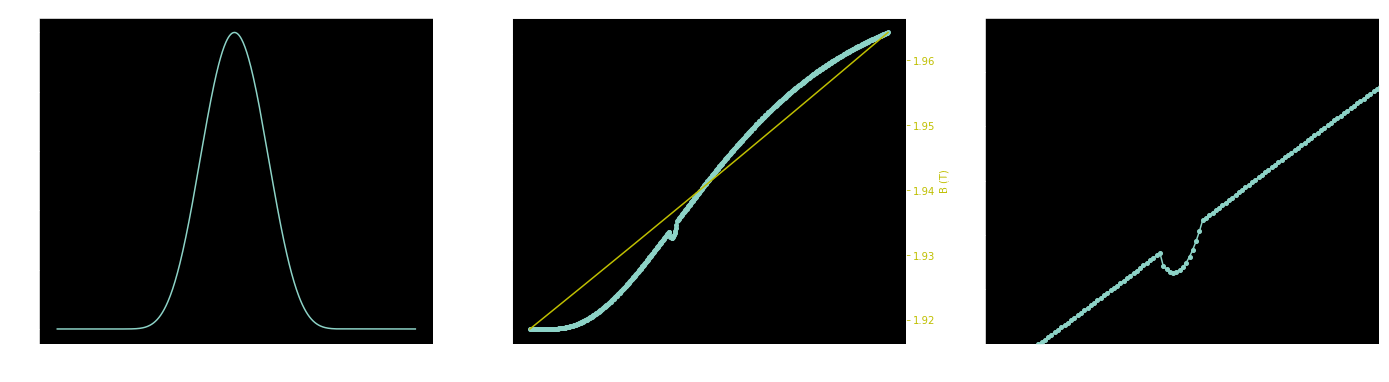

In [7]:
plt.figure(figsize=(24,6))

plt.subplot(1, 3, 1)
radius_arr, dens_prof = density_profile(n=7, n_points=600)
#dens_prof = density_add_bump(radius_arr, dens_prof, bump_pos=1.5, bump_size=0.2, bump_height=0.4)
plt.plot(radius_arr, dens_prof)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')

plt.gca().invert_xaxis()

###

ax1 = plt.subplot(1, 3, 2)
rs, ns = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=10e19, r_vacuum=0.002)
bs = magnetic_field_profile(rs, mag_field_ref=2.5, pos_ref=1.65)
rs = rs[0] - rs
ns = density_add_bump(rs, ns, bump_pos=0.02, bump_size=0.001, bump_height=.95, bug=True)
plt.plot(rs, ns, '-o', markersize=4)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')

ax2 = ax1.twinx()
ax2.plot(rs, bs, 'y-')
ax2.set_ylabel('B (T)', color='y')
ax2.tick_params('y', colors='y')

###

plt.subplot(1, 3, 3)
plt.plot(rs, ns, '-o', markersize=4)

plt.xlim(0.015, 0.025)
plt.ylim(0.2e20, 0.5e20)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')

plt.show()

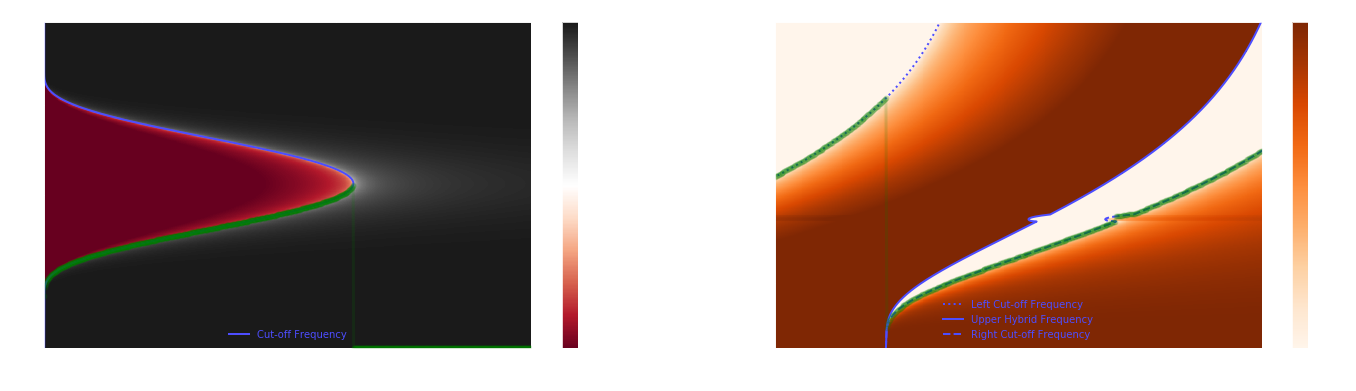

In [8]:
### Options ###

#colormap = 'Oranges'
#colormap = 'inferno'
#norm_type = 'log'

colormap, norm_type = 'Oranges', 'linear'
#colormap, norm_type = 'inferno', 'log'

cutoff_freq_color = (.3, .3, 1)

### Calcs ###

fs_O = np.sort(np.hstack([np.logspace(0, 11, 500), np.linspace(1, 1e11, 500)]))
fs_O = np.linspace(1, 1e11, 1024)
fs_X = np.linspace(40e9, 100e9, 500)

n_index_O = refractive_matrix_O(dens_prof, fs_O, squared=True)
reflect_pos_O = np.argmax(n_index_O <= 0, axis=1)
n_index_X = refractive_matrix_X(ns, fs_X, mag_field=bs, squared=False)
reflect_pos_X = np.argmax(n_index_X <= 0, axis=1)

normalizs = {
    'linear': colors.Normalize(vmin=0, vmax=1),
    'log': colors.LogNorm(),
    'symlog': colors.SymLogNorm(linthresh=1e-3, clip=True, vmin=-10, vmax=10)
}
norm = normalizs[norm_type]

if norm_type == 'log':
    n_index_X[n_index_X < 1e-3] = 1e-3

### PLOTS ###

plt.figure(figsize=(24,6))

# O mode

ax_O = plt.subplot(1, 2, 1)

plt.pcolormesh(fs_O/1e9, radius_arr, n_index_O.T, cmap='RdGy', norm=colors.SymLogNorm(linthresh=1e-3, clip=True, vmin=-1, vmax=1))
cbar = plt.colorbar()
cbar.ax.set_ylabel('n')

plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('R (m)')
plt.title('Refractive Matrix of O-mode')

ax_O_cutoff = ax_O.twiny()

ax_O_cutoff.plot(cutoff_freq_O(dens_prof)/1e9, radius_arr, '-', color=cutoff_freq_color, linewidth=2, label='Cut-off Frequency')

ax_O_cutoff.plot(fs_O/1e9, radius_arr[reflect_pos_O], 'g-o', linewidth=3, markersize=5, alpha=0.15)

ax_O_cutoff.set_xlim(0,100)
ax_O_cutoff.set_ylim(radius_arr.min(), radius_arr.max())
ax_O_cutoff.xaxis.set_ticklabels('')

leg = plt.legend(loc='lower center', framealpha=0)

for text in leg.texts:
    text.set_color(cutoff_freq_color)

# X mode

ax_X = plt.subplot(1, 2, 2)

plt.pcolormesh(fs_X/1e9, rs, n_index_X.T, cmap=colormap, norm=norm)
cbar = plt.colorbar()
cbar.ax.set_ylabel('n$^2$')

plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('R (m)')
plt.title('Refractive Matrix of X-mode')

ax_X_cutoff = ax_X.twiny()

fL, fR = cutoff_freq_X(ns, bs)

ax_X_cutoff.plot(fL/1e9, rs, ':', color=cutoff_freq_color, linewidth=2, label='Left Cut-off Frequency')
ax_X_cutoff.plot(upper_hybrid_frequency(ns, bs)/1e9, rs, '-', color=cutoff_freq_color, linewidth=2, label='Upper Hybrid Frequency')
ax_X_cutoff.plot(fR/1e9, rs, '--', color=cutoff_freq_color, linewidth=2, label='Right Cut-off Frequency')

ax_X_cutoff.plot(fs_X/1e9, rs[reflect_pos_X], 'g-o', linewidth=3, markersize=5, alpha=0.15)

ax_X_cutoff.set_xlim(40,100)
ax_X_cutoff.set_ylim(rs.min(), rs.max())
ax_X_cutoff.xaxis.set_ticklabels('')

leg = plt.legend(loc='lower center', framealpha=0)

for text in leg.texts:
    text.set_color(cutoff_freq_color)

plt.show()

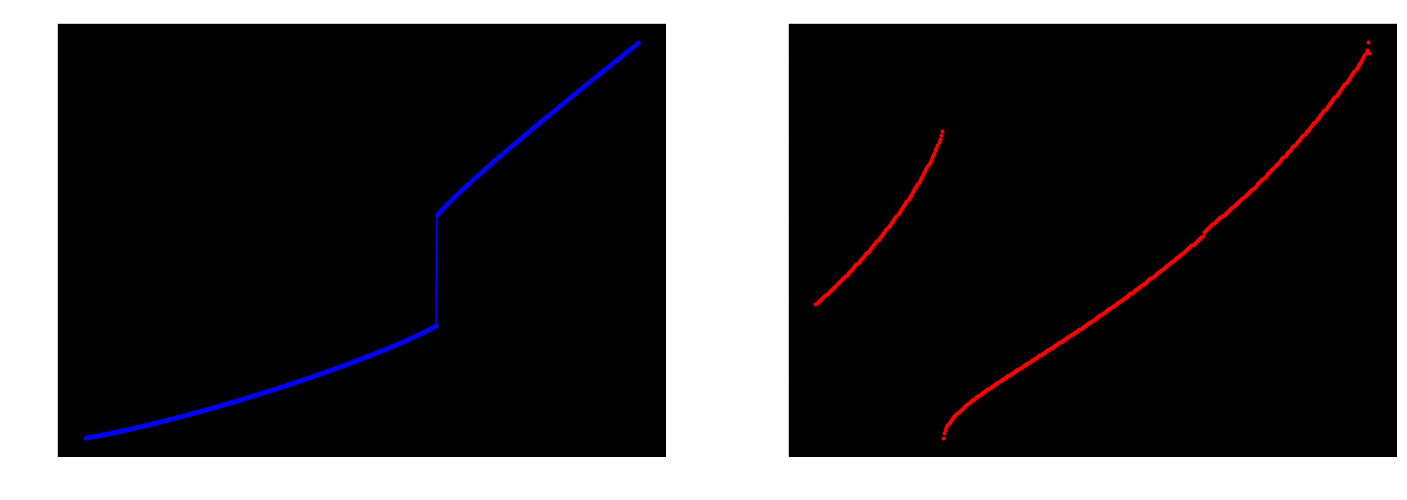

In [9]:
n_index_O = refractive_matrix_O(dens_prof, fs_O)
phi_O = phase_delay(fs_O, radius_arr, n_index_O)
n_index_X = refractive_matrix_X(ns, fs_X, mag_field=bs)
phi_X = phase_delay(fs_X, rs, n_index_X, refraction_epsilon=1e-6)

plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, phi_O, 'b.-')

plt.title('Phase Delay of O-Mode')
plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('$\Delta$$\phi$ (rad)')

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, phi_X, 'r.')

plt.title('Phase Delay of X-Mode')
plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('$\Delta$$\phi$ (rad)')

plt.show()

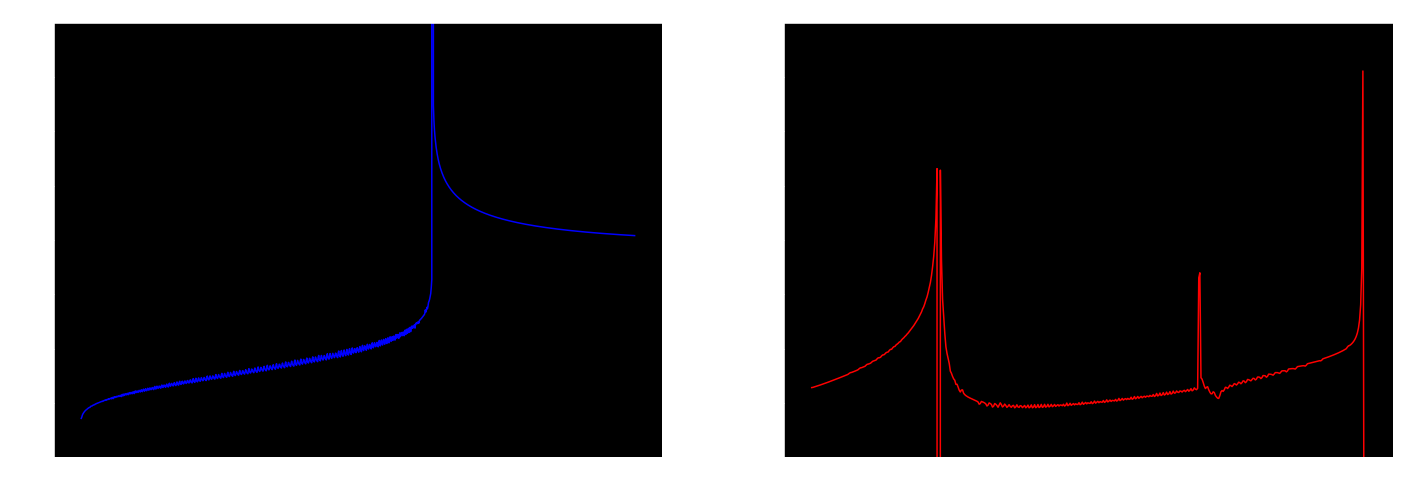

In [10]:
delta_t_O = time_delay(fs_O, phi_O)
delta_t_X = time_delay(fs_X, phi_X)

plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, delta_t_O*1e9, 'b-')

plt.title('Time Delay of O-Mode')
plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('$\Delta$t (ns)')

plt.ylim(0, 20)

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, delta_t_X*1e9, 'r-')

plt.title('Time Delay of X-Mode')
plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('$\Delta$t (ns)')

plt.ylim(0, 2)

plt.show()

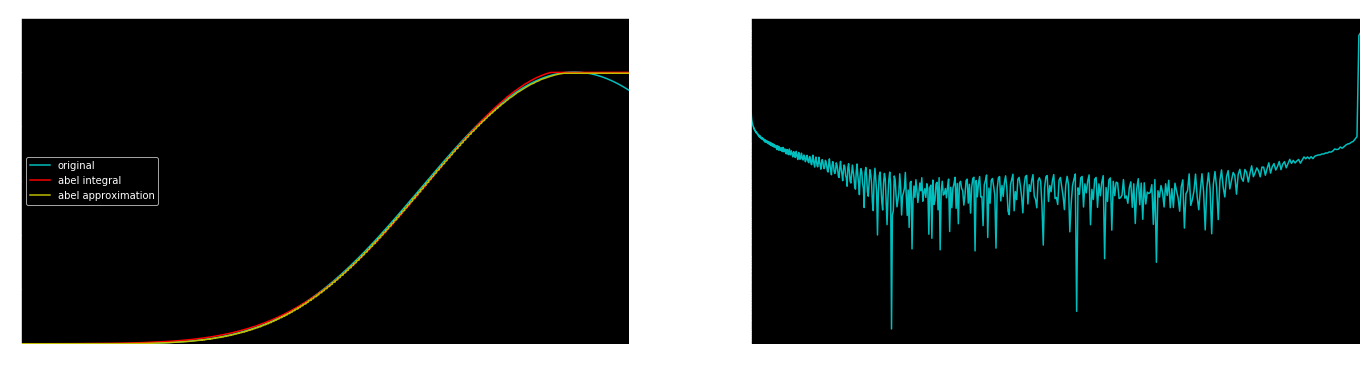

In [11]:
dens_arr_to_calc = plasma_density(fs_O)
radius_calc, _ = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.03, other_method=False)
radius_calc_other, _ = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)
#a, b, c, d = CalcInvPerfO(fs_O, delta_t_O, vacd=.95, initpts=0)

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)

plt.plot(radius_arr, dens_prof, 'c-', label='original')
plt.plot(radius_calc, dens_arr_to_calc, 'r-', label='abel integral')
plt.plot(radius_calc_other, dens_arr_to_calc, 'y-', label="abel approximation")
#plt.plot(a + radius_arr[0], b, '-', color='orange', label="jorge's")

plt.xlim(1.15, 1.7)
plt.ylim(0, 6e19)

plt.legend(loc='center left')

plt.subplot(1, 2, 2)

plt.semilogy(dens_arr_to_calc[1:], np.abs(radius_calc[1:] - radius_calc_other[1:]), 'c-',)

plt.xlim(0, 5e19)

plt.show()

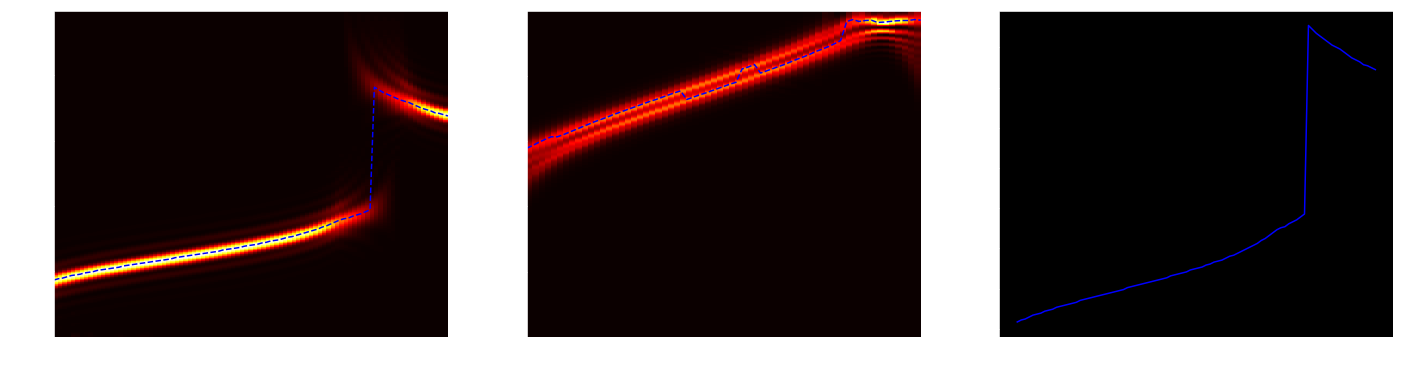

In [12]:
f_sampling = 1e6

fs, ts, spectrum = beat_spectrogram(fs_O, delta_t_O, fs=f_sampling)
fs1, ts1, spectrum1 = spectrogram(np.cos(phi_O[phi_O < 2000]), fs=f_sampling, nperseg=136, nfft=2048, noverlap=128)
freq_inds = fs < .25e6
time_inds = ts < 800e-6

beat_sig = beat_signal(fs, spectrum)
beat_sig1 = beat_signal(fs1, spectrum1)

d_fs = fs_O[1] - fs_O[0]
sweep_rate = f_sampling * d_fs
delta_t_noise = beat_sig1 / sweep_rate
fs_noise = ts1 * sweep_rate

plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)

plt.pcolormesh(ts[time_inds]*1e6, fs[freq_inds]*1e-6, spectrum[freq_inds, :][:, time_inds], cmap='hot')
plt.plot(ts[time_inds]*1e6, beat_sig[time_inds]*1e-6, '--b')

plt.xlabel('t (ms)')
plt.ylabel('f$_b$ (MHz)')

plt.subplot(1, 3, 2)

plt.pcolormesh(ts1*1e6, fs1*1e-6, spectrum1, cmap='hot')
plt.plot(ts1*1e6, beat_sig1*1e-6, '--b')

plt.xlabel('t (ms)')
plt.ylabel('f$_b$ (MHz)')

plt.subplot(1, 3, 3)

plt.plot(ts[time_inds], beat_sig[time_inds], 'b-')

plt.show()

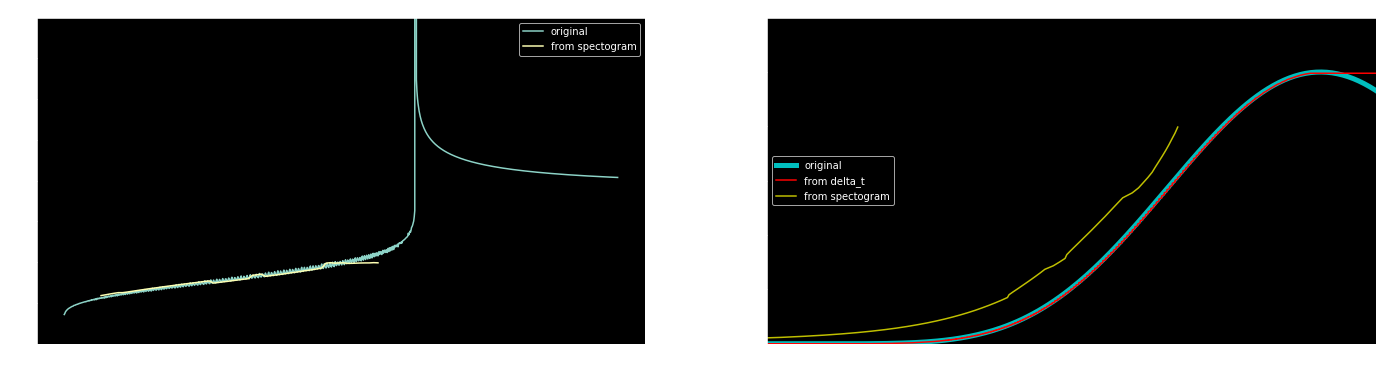

In [13]:
dens_arr_to_calc = plasma_density(fs_O)
#radius_calc = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.03, other_method=False)
radius_calc_other, _ = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)
radius_noise, dens_noise = abel_inversion(fs_noise, delta_t_noise, pos_antenna=radius_arr[0], other_method=True)
#radius_noise, dens_noise, _, _ = CalcInvPerfO(fs_noise, delta_t_noise, vacd=.92, initpts=100)

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)

plt.plot(fs_O*1e-9, delta_t_O*1e9, label='original')
plt.plot(fs_noise*1e-9, delta_t_noise*1e9, label='from spectogram')

plt.ylim(0, 20)

plt.legend()

plt.subplot(1, 2, 2)

plt.plot(radius_arr, dens_prof, 'c-', label='original', lw=5)
plt.plot(radius_calc_other, dens_arr_to_calc, 'r-', label='from delta_t')
plt.plot(radius_noise, dens_noise, 'y-', label="from spectogram")
#plt.plot(a + radius_arr[0], b, '-', color='orange', label="jorge's")

plt.xlim(1.15, 1.7)
plt.ylim(0, 6e19)

plt.legend(loc='center left')

plt.show()